<a href="https://colab.research.google.com/github/AlirezaPNouri/Papers/blob/main/Case_Study_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This code is used to generate the experimental results for the case study, story #56

In [ ]:
import pickle
import re
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer


In [ ]:
stopwords = ['i','me','my','myself','we','our','ours','ourselves','you','your','yours','yourself','yourselves','he','him','his','himself','she','her','hers','herself','it','its','itself','they','them','their','theirs','themselves','what','which','who','whom','this','that','these','those','am','is','are','was','were','be','been','being','have','has','had','having','do','does','did','doing','a','an','the','and','but','if','or','because','as','until','while','of','at','by','for','with','about','against','between','into','through','during','before','after','above','below','to','from','up','down','in','out','on','off','over','under','again','further','then','once','here','there','when','where','why','how','all','any','both','each','few','more','most','other','some','such','no','nor','not','only','own','same','so','than','too','very','s','t','can','will','just','don','should','now', 'of', 'within']
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
df = pickle.load(open('drive/MyDrive/temp/data_r/Proposed/df.p', 'rb'))
story_data = pickle.load(open('drive/MyDrive/temp/data_r/final_results_proposed.p', 'rb'))
df_embedding = pickle.load(open('drive/MyDrive/temp/data_r/Proposed/Embed_dict.p', 'rb'))

final_results_proposed = pickle.load(open('drive/MyDrive/temp/data_r/final_results_proposed.p', 'rb'))
final_results_bert = pickle.load(open('drive/MyDrive/temp/data_r/final_results_bert.p', 'rb'))
final_results_ji = pickle.load(open('drive/MyDrive/temp/data_r/final_results_ji.p', 'rb'))
final_results_doc2vec = pickle.load(open('drive/MyDrive/temp/data_r/final_results_doc2vec.p', 'rb'))
final_results_doc2vec_n = pickle.load(open('drive/MyDrive/temp/data_r/n_final_results_doc2vec.p', 'rb'))

total_doc_embedding_cls = pickle.load(open('drive/MyDrive/temp/data_r/Proposed/total_docs_clusters_wo_stopwords.p', 'rb'))
list_of_timestamps = pickle.load(open('drive/MyDrive/temp/data_r/Proposed/list_of_timestamps.p', 'rb'))

In [ ]:
def special_char_remover(str_):
  """
  This function removes any special characters from a text
  Arguments:
    str_: a string
  Returns:
    A string
  """
  return ' '.join(''.join(w for w in m if w.isalnum()) for m in str_.split(' '))

In [ ]:
def pre_process(text):
    # lowercase
    text = text.lower()
    # remove tags
    text = re.sub("", "", text)
    # remove special characters and digits
    text = re.sub("(\\d|\\W)+", " ", text)
    return text

In [ ]:
def stopword_remover(str_, stopwords_):
  words = word_tokenize(str_)
  ps = PorterStemmer()
  temp_list = list()
  for ele in words:
    if ele not in stopwords_:
      temp_list.append(ps.stem(ele))
  return ' '.join(temp_list)



In [ ]:
data_content = dict()
for index, row in df.iterrows():
  data_content[row['id']] = stopword_remover(pre_process(special_char_remover(row['content'])), stopwords)

In [ ]:
cv = CountVectorizer(max_df=0.85, stop_words=stopwords)

In [ ]:
word_count_vector = cv.fit_transform(data_content.values())

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
tfidf_transformer.fit(word_count_vector)

TfidfTransformer()

In [ ]:
def sort_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)

In [ ]:
def extract_topn_from_vector(feature_names, sorted_items, topn=10):
    """get the feature names and tf-idf score of top n items"""
    
    #use only topn items from vector
    sorted_items = sorted_items[:topn]
    score_vals = []
    feature_vals = []
    
    # word index and corresponding tf-idf score
    for idx, score in sorted_items:
        
        #keep track of feature name and its corresponding score
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])
    #create a tuples of feature,score
    #results = zip(feature_vals,score_vals)
    results= {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]]=score_vals[idx]
    
    return results

In [ ]:
# you only needs to do this once, this is a mapping of index to 
feature_names=cv.get_feature_names_out()
top_keywords = dict()
for ind, doc in data_content.items():
  # get the document that we want to extract keywords from
  # doc=data_content[51167]
  #generate tf-idf for the given document
  tf_idf_vector=tfidf_transformer.transform(cv.transform([doc]))
  #sort the tf-idf vectors by descending order of scores
  sorted_items=sort_coo(tf_idf_vector.tocoo())
  #extract only the top n; n here is 10
  keywords=extract_topn_from_vector(feature_names,sorted_items,20)
  # now print the results
  # print("\n=====Doc=====")
  # print(doc)
  # print("\n===Keywords===")
  temp_list = dict()
  for k, val in keywords.items():
    temp_list[k] = val
        # print(k,keywords[k])
  top_keywords[ind] = temp_list

In [ ]:
def jaccard_similarity(text1, text2):
  set_text1 = set(text1)
  set_text2 = set(text2)

  return len(set_text1.intersection(set_text2)) / len(set_text1.union(set_text2))

In [ ]:
sample_proposed = story_data[0.9][1]
keyword_story_proposed = dict()
for doc_1, doc_2 in zip(sample_proposed[:-1], sample_proposed[1:]):
  keyword_story_proposed[doc_1] = jaccard_similarity(top_keywords[doc_1].keys(), top_keywords[doc_2].keys())


sample_bert = final_results_bert[0.9][1]
keyword_story_bert = dict()
for doc_1, doc_2 in zip(sample_bert[:-1], sample_bert[1:]):
  keyword_story_bert[doc_1] = jaccard_similarity(top_keywords[doc_1].keys(), top_keywords[doc_2].keys())

sample_ji = final_results_ji[0.9][1]
keyword_story_ji = dict()
for doc_1, doc_2 in zip(sample_ji[:-1], sample_ji[1:]):
  keyword_story_ji[doc_1] = jaccard_similarity(top_keywords[doc_1].keys(), top_keywords[doc_2].keys())

sample_doc2vec = final_results_doc2vec[0.9][1]
keyword_story_doc2vec = dict()
for doc_1, doc_2 in zip(sample_doc2vec[:-1], sample_doc2vec[1:]):
  keyword_story_doc2vec[doc_1] = jaccard_similarity(top_keywords[doc_1].keys(), top_keywords[doc_2].keys())

In [ ]:
total_dict_proposed = dict()

for total in range(len(story_data[0.9])):
  sampl = story_data[0.9][total]
  keyword_story = dict()
  for doc_1, doc_2 in zip(sampl[:-1], sampl[1:]):
    keyword_story[doc_1] = jaccard_similarity(top_keywords[doc_1].keys(), top_keywords[doc_2].keys())
  total_dict_proposed[total] = keyword_story



total_dict_bert = dict()

for total in range(len(final_results_bert[0.9])):
  sampl = final_results_bert[0.9][total]
  keyword_story = dict()
  for doc_1, doc_2 in zip(sampl[:-1], sampl[1:]):
    keyword_story[doc_1] = jaccard_similarity(top_keywords[doc_1].keys(), top_keywords[doc_2].keys())
  total_dict_bert[total] = keyword_story


total_dict_ji = dict()

for total in range(len(final_results_ji[0.9])):
  sampl = final_results_ji[0.9][total]
  keyword_story = dict()
  for doc_1, doc_2 in zip(sampl[:-1], sampl[1:]):
    keyword_story[doc_1] = jaccard_similarity(top_keywords[doc_1].keys(), top_keywords[doc_2].keys())
  total_dict_ji[total] = keyword_story


total_dict_doc2vec = dict()

for total in range(len(final_results_doc2vec[0.9])):
  sampl = final_results_doc2vec[0.9][total]
  keyword_story = dict()
  for doc_1, doc_2 in zip(sampl[:-1], sampl[1:]):
    keyword_story[doc_1] = jaccard_similarity(top_keywords[doc_1].keys(), top_keywords[doc_2].keys())
  total_dict_doc2vec[total] = keyword_story

In [ ]:
story_picked = 4
print(len(total_dict_proposed[story_picked]))
print(len(total_dict_bert[story_picked]))
print(len(total_dict_ji[story_picked]))
print(len(total_dict_doc2vec[story_picked]))

51
38
57
39


In [ ]:
# chan_dict_proposed = dict()
# for st in total_dict_proposed.keys():
#   if len(total_dict_proposed[st]) > 4:
#     chan_dict_proposed[st] =sum(list(total_dict_proposed[st].values()))
# ind = sorted(chan_dict_proposed.values())
# list_of_stories_proposed = list()
# # for z in range(len(ind)):
# for t, v in chan_dict_proposed.items():
#   if v == ind[-1]:
#     print(t, ' -> ', total_dict_proposed[t])
#     list_of_stories_proposed.append(t)



# chan_dict_bert = dict()
# for st in total_dict_bert.keys():
#   if len(total_dict_bert[st]) > 4:
#     chan_dict_bert[st] =sum(list(total_dict_bert[st].values()))
# ind = sorted(chan_dict_bert.values())
# list_of_stories_bert = list()
# # for z in range(len(ind)):
# for t, v in chan_dict_bert.items():
#   if v == ind[-1]:
#     print(t, ' -> ', total_dict_bert[t])
#     list_of_stories_bert.append(t)


# chan_dict_ji = dict()
# for st in total_dict_ji.keys():
#   if len(total_dict_ji[st]) > 4:
#     chan_dict_ji[st] =sum(list(total_dict_ji[st].values()))
# ind = sorted(chan_dict_ji.values())
# list_of_stories_ji = list()
# # for z in range(len(ind)):
# for t, v in chan_dict_ji.items():
#   if v == ind[-1]:
#     print(t, ' -> ', total_dict_ji[t])
#     list_of_stories_ji.append(t)


# chan_dict_doc2vec = dict()
# for st in total_dict_doc2vec.keys():
#   if len(total_dict_doc2vec[st]) > 4:
#     chan_dict_doc2vec[st] =sum(list(total_dict_doc2vec[st].values()))
# ind = sorted(chan_dict_doc2vec.values())
# list_of_stories_doc2vec = list()
# # for z in range(len(ind)):
# for t, v in chan_dict_doc2vec.items():
#   if v == ind[-1]:
#     print(t, ' -> ', total_dict_doc2vec[t])
#     list_of_stories_doc2vec.append(t)

In [ ]:
story_picked = 83
# story_picked = 56

print('CoRBS')

for story in total_dict_proposed[story_picked]:
  print(story, '  ', list(top_keywords[story].keys()))
print(len(total_dict_proposed[story_picked]))
print('\n\n\n\n')

print('Bert')
for story in total_dict_bert[story_picked]:
  print(story, '  ', list(top_keywords[story].keys()))
print(len(total_dict_bert[story_picked]))

print('\n\n\n\n')
print('Entity-set based')
for story in total_dict_ji[story_picked]:
  print(story, '  ', list(top_keywords[story].keys()))
print(len(total_dict_ji[story_picked]))

print('\n\n\n\n')
print('doc2vec')
for story in total_dict_doc2vec[story_picked]:
  print(story, '  ', list(top_keywords[story].keys()))
print(len(total_dict_doc2vec[story_picked]))

CoRBS
733443    ['ctx', 'carboxyl', 'asp', 'conform', 'semicarbazid', 'phospholipid', 'permeabil', 'groupmodifi', 'membran', 'modif', 'asn', 'group', 'vesicl', 'structur', 'nativ', 'zwitterion', 'trifluoroethanolinduc', 'polydiacetylenelipid', 'naja', 'lipidbound']
538330    ['ru', 'ecl', 'nm', 'signal', 'hcr', 'ratiometr', 'hairpin', 'rdrp', 'reaction', 'biosensor', 'gene', 'probe', 'nucleic', 'amplif', 'gradual', 'dna', 'detect', 'modifi', 'acid', 'end']
501482    ['hljdd', 'uc', 'compon', 'gene', 'dock', 'network', 'coliti', 'ulcer', 'ppi', 'molecular', 'bioactiv', 'pharmacolog', 'verifi', 'target', 'signal', 'bind', 'activ', 'pathway', 'abil', 'multipathway']
614607    ['protein', 'lyt', 'utr', 'cruzi', 'mlyt', 'klyt', 'proteom', 'parasit', 'mrna', 'trypomastigot', 'bait', 'lcm', 'hypothet', 'bind', 'regul', 'spectrometri', 'motif', 'gene', 'bound', 'regulatori']
705096    ['crp', 'apheresi', 'patient', 'plasma', 'level', 'dramat', 'present', 'sever', 'sign', 'seven', 'comorbid', '

In [ ]:
print(total_dict_proposed[story_picked])

{733443: 0.0, 538330: 0.05263157894736842, 501482: 0.05263157894736842, 614607: 0.0, 705096: 0.0, 691973: 0.0, 695007: 0.0, 125622: 0.0, 640746: 0.0, 579564: 0.0, 731564: 0.0, 534828: 0.0, 691757: 0.02564102564102564, 543885: 0.0, 51157: 0.0, 50586: 0.02564102564102564, 543306: 0.0, 775204: 0.0, 634083: 0.0, 610772: 0.0, 703619: 0.0, 50820: 0.0, 650456: 0.0, 530729: 0.0, 563747: 0.0, 92988: 0.02564102564102564, 23936: 0.0, 662042: 0.02564102564102564, 770998: 0.0, 711972: 0.0, 769272: 0.0, 714878: 0.0, 625414: 0.02564102564102564, 655983: 0.0, 507522: 0.02564102564102564, 135984: 0.02564102564102564, 588902: 0.0, 129957: 0.02564102564102564, 51091: 0.0, 85977: 0.02564102564102564, 641631: 0.0, 675858: 0.0, 81355: 0.0, 713586: 0.0, 50947: 0.0, 748209: 0.0, 114811: 0.02564102564102564, 764882: 0.0, 184331: 0.0, 142474: 0.0, 711756: 0.0, 774591: 0.0, 536160: 0.02564102564102564, 165446: 0.0, 160545: 0.02564102564102564, 51147: 0.02564102564102564, 715517: 0.0, 23586: 0.02564102564102564}


In [ ]:

# # importing package
# import matplotlib.pyplot as plt
# import numpy as np
# plt.figure(figsize=(10,5))
# # create data
# y = list(total_dict_proposed[story_picked].values())
# x = [x for x in range(len(total_dict_proposed[story_picked].keys()))]
# plt.plot(x, y, label = "Our CoRBS ", linestyle="-." )
# plt.ylabel('Differentiate of Jaccard index')
# plt.xlabel('Documents in story #56')

# y = list(total_dict_bert[list_of_stories_bert[0]].values())
# x = [x for x in range(len(total_dict_bert[list_of_stories_bert[0]].keys()))]
# plt.plot(x, y, label = "BERT ", linestyle="-." )

# y = list(total_dict_ji[list_of_stories_ji[0]].values())
# x = [x for x in range(len(total_dict_ji[list_of_stories_ji[0]].keys()))]
# plt.plot(x, y, label = "Entity-set based", linestyle="-." )

# y = list(total_dict_doc2vec[list_of_stories_doc2vec[0]].values())
# x = [x for x in range(len(total_dict_doc2vec[list_of_stories_doc2vec[0]].keys()))]
# plt.plot(x, y, label = "doc2vec ", linestyle="-." )

# plt.legend()
# plt.show()


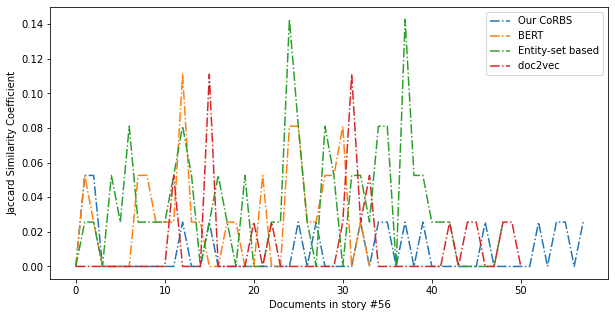

In [ ]:
# importing package
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(10,5))
# create data
y = list(total_dict_proposed[story_picked].values())
x = [x for x in range(len(total_dict_proposed[story_picked].keys()))]
plt.plot(x, y, label = "Our CoRBS ", linestyle="-." )
plt.ylabel('Jaccard Similarity Coefficient')
plt.xlabel('Documents in story #56')

y = list(total_dict_bert[story_picked].values())
x = [x for x in range(len(total_dict_bert[story_picked].keys()))]
plt.plot(x, y, label = "BERT ", linestyle="-." )

y = list(total_dict_ji[story_picked].values())
x = [x for x in range(len(total_dict_ji[story_picked].keys()))]
plt.plot(x, y, label = "Entity-set based", linestyle="-." )

y = list(total_dict_doc2vec[story_picked].values())
x = [x for x in range(len(total_dict_doc2vec[story_picked].keys()))]
plt.plot(x, y, label = "doc2vec ", linestyle="-." )

plt.legend()
plt.show()

In [ ]:
word_cloud_frequency_proposed = dict()
for story in total_dict_proposed[story_picked]:
  story_text = list()
  for word_, freq in top_keywords[story].items():
    for ind in range(int(100*freq)):
      story_text.append(word_)
  word_cloud_frequency_proposed[story] = ' '.join(story_text)


word_cloud_frequency_bert = dict()
for story in total_dict_bert[story_picked]:
  story_text = list()
  for word_, freq in top_keywords[story].items():
    for ind in range(int(100*freq)):
      story_text.append(word_)
  word_cloud_frequency_bert[story] = ' '.join(story_text)


word_cloud_frequency_ji = dict()
for story in total_dict_ji[story_picked]:
  story_text = list()
  for word_, freq in top_keywords[story].items():
    for ind in range(int(100*freq)):
      story_text.append(word_)
  word_cloud_frequency_ji[story] = ' '.join(story_text)


word_cloud_frequency_doc2vec = dict()
for story in total_dict_doc2vec[story_picked]:
  story_text = list()
  for word_, freq in top_keywords[story].items():
    for ind in range(int(100*freq)):
      story_text.append(word_)
  word_cloud_frequency_doc2vec[story] = ' '.join(story_text)

---------- 733443 ------------


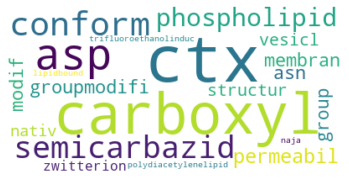


---------- 538330 ------------


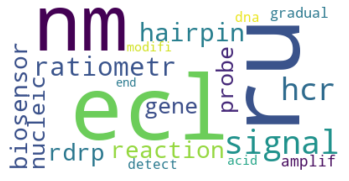


---------- 501482 ------------


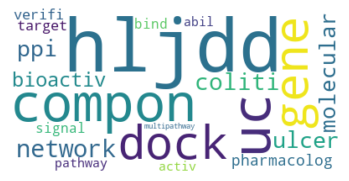


---------- 614607 ------------


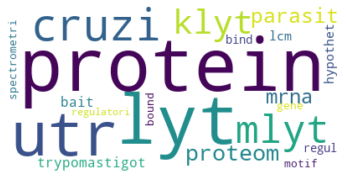


---------- 705096 ------------


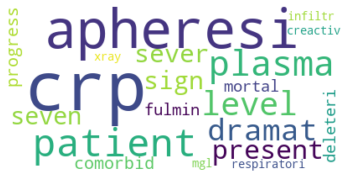


---------- 691973 ------------


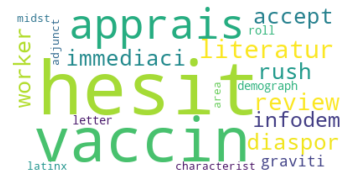


---------- 695007 ------------


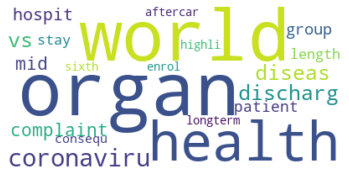


---------- 125622 ------------


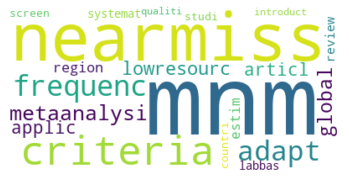


---------- 640746 ------------


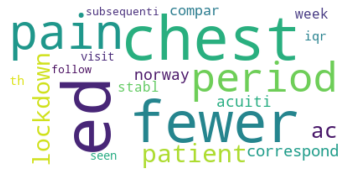

In [ ]:
# to plot word cloud
import matplotlib.pyplot as plt
from wordcloud import WordCloud
for story in total_dict_proposed[story_picked]:
  word_cloud = WordCloud(collocations = False, background_color = 'white').generate(word_cloud_frequency_proposed[story])
  print('---------- {} ------------'.format(story))
  plt.imshow(word_cloud, interpolation='bilinear')
  plt.axis("off")
  plt.show()
  print()

---------- 733443 ------------


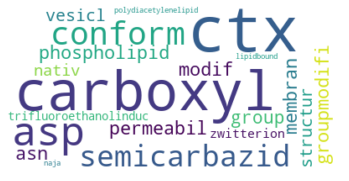


---------- 687363 ------------


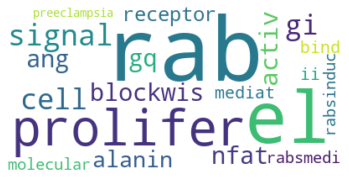


---------- 512545 ------------


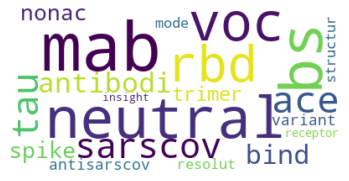


---------- 51025 ------------


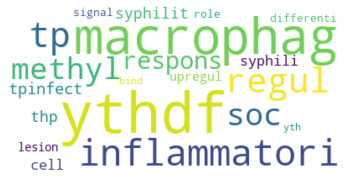


---------- 23780 ------------


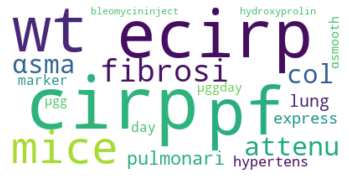


---------- 69939 ------------


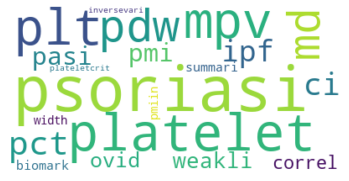


---------- 702542 ------------


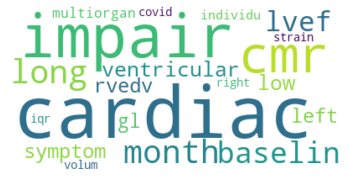


---------- 674108 ------------


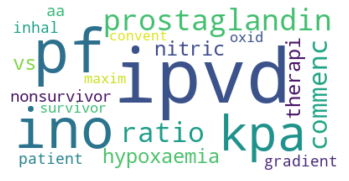


---------- 568088 ------------


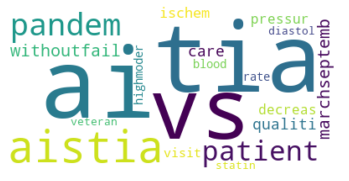


---------- 590264 ------------


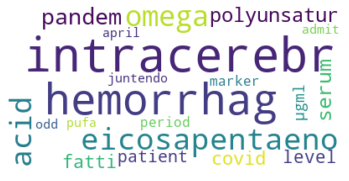


---------- 643946 ------------


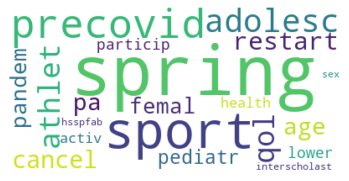


---------- 690774 ------------


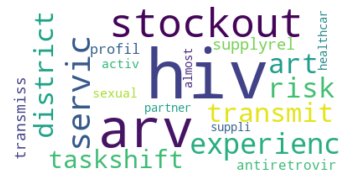


---------- 625084 ------------


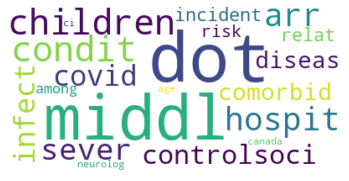


---------- 510283 ------------


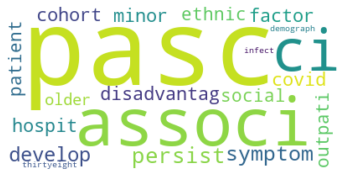


---------- 23974 ------------


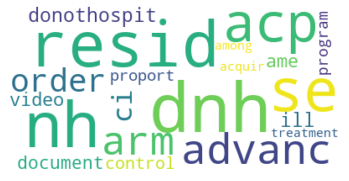


---------- 526067 ------------


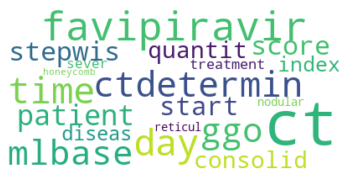


---------- 544900 ------------


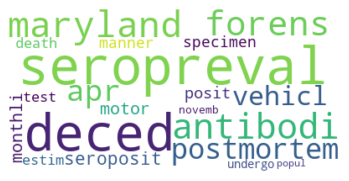


---------- 493866 ------------


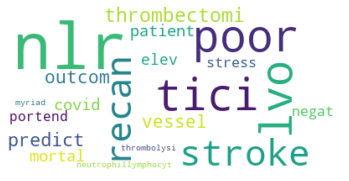


---------- 526687 ------------


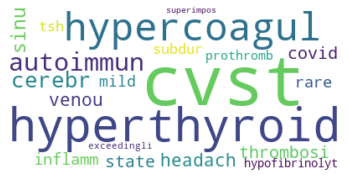


---------- 717819 ------------


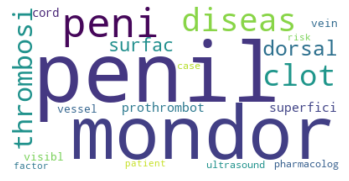


---------- 705416 ------------


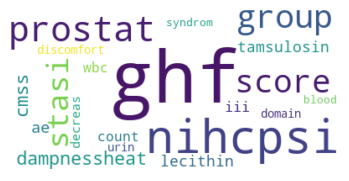


---------- 51085 ------------


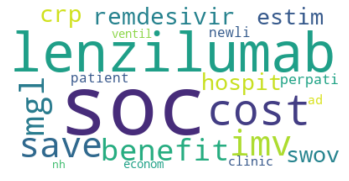


---------- 134932 ------------


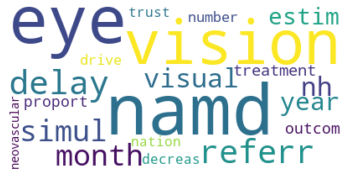


---------- 59055 ------------


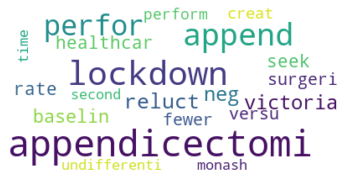


---------- 175982 ------------


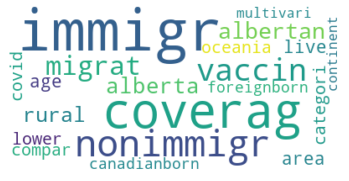


---------- 186500 ------------


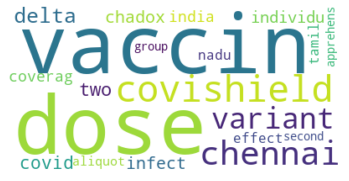


---------- 184681 ------------


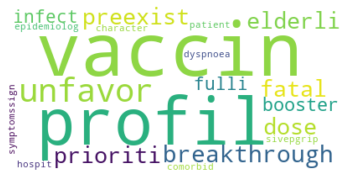


---------- 144963 ------------


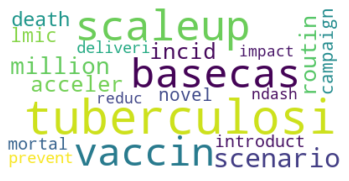


---------- 642950 ------------


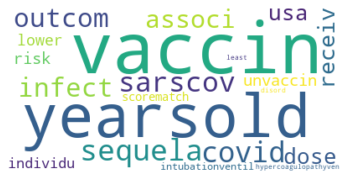


---------- 602505 ------------


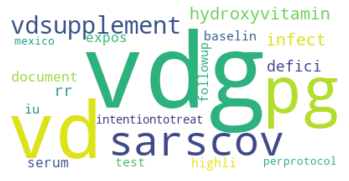


---------- 654238 ------------


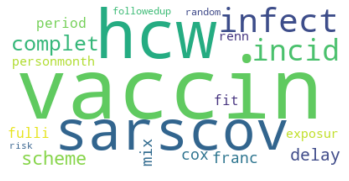


---------- 163637 ------------


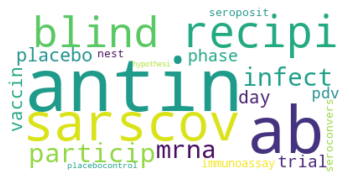


---------- 51186 ------------


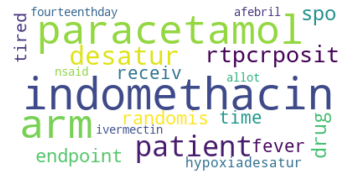


---------- 559169 ------------


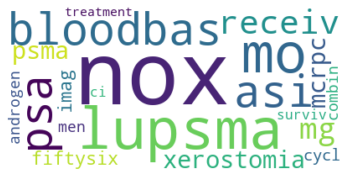

In [ ]:
# to plot word cloud
import matplotlib.pyplot as plt
from wordcloud import WordCloud
for story in total_dict_bert[story_picked]:
  word_cloud = WordCloud(collocations = False, background_color = 'white').generate(word_cloud_frequency_bert[story])
  print('---------- {} ------------'.format(story))
  plt.imshow(word_cloud, interpolation='bilinear')
  plt.axis("off")
  plt.show()
  print()

---------- 733443 ------------


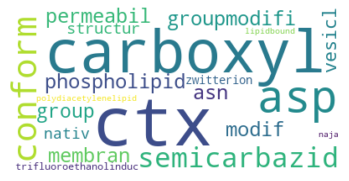


---------- 636658 ------------


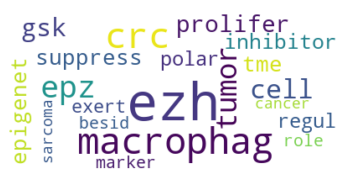


---------- 172197 ------------


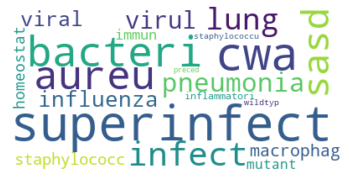


---------- 576857 ------------


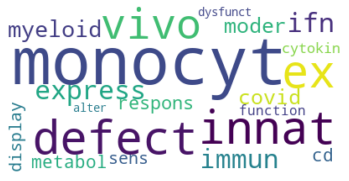


---------- 660616 ------------


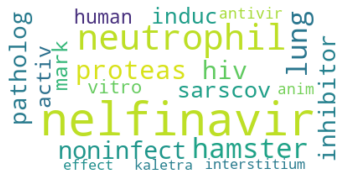


---------- 759025 ------------


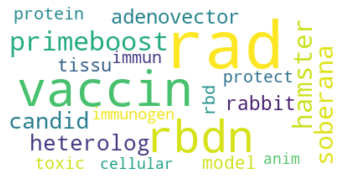


---------- 57051 ------------


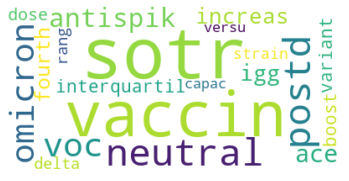


---------- 749822 ------------


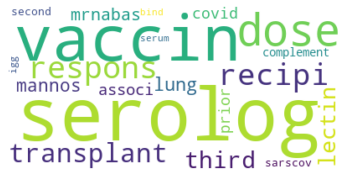


---------- 539569 ------------


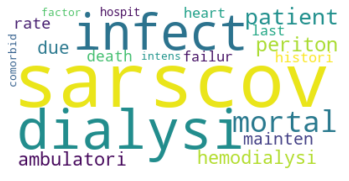


---------- 773552 ------------


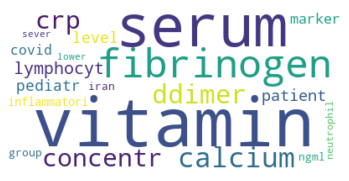


---------- 724432 ------------


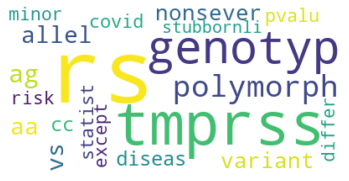


---------- 64705 ------------


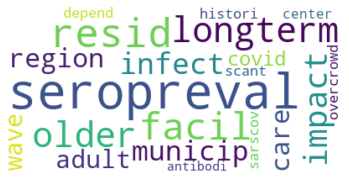


---------- 666245 ------------


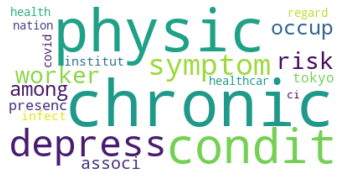


---------- 540177 ------------


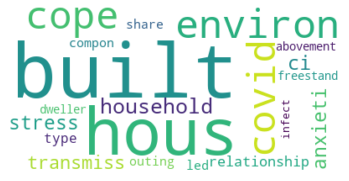


---------- 606592 ------------


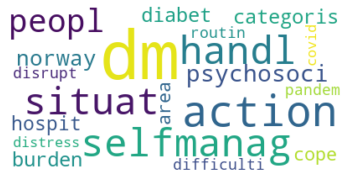


---------- 92679 ------------


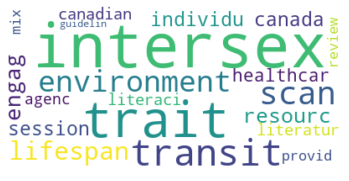


---------- 688669 ------------


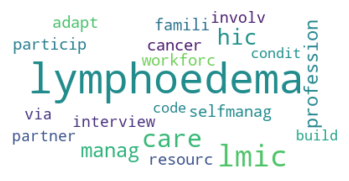


---------- 76728 ------------


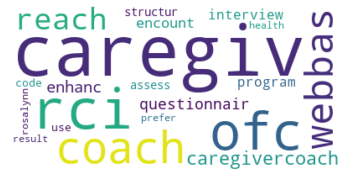


---------- 728638 ------------


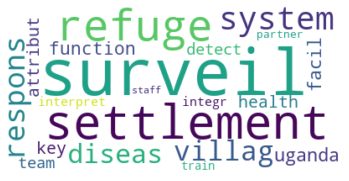


---------- 646543 ------------


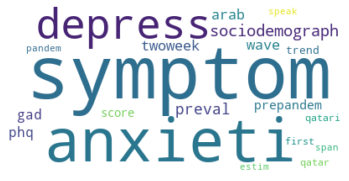


---------- 732223 ------------


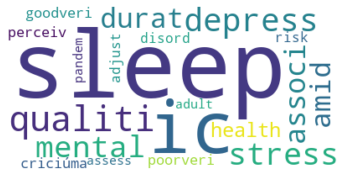


---------- 619972 ------------


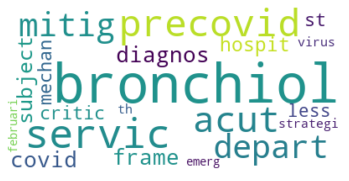


---------- 540039 ------------


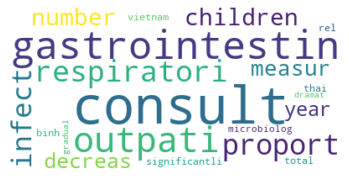


---------- 600218 ------------


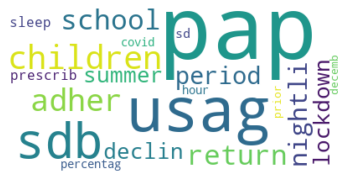


---------- 662811 ------------


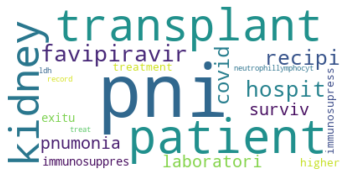


---------- 544116 ------------


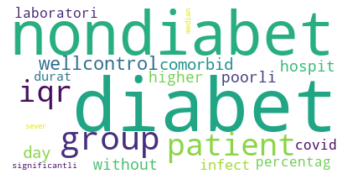


---------- 730959 ------------


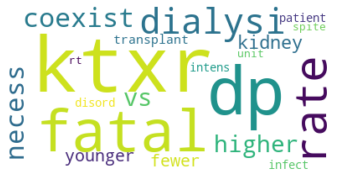


---------- 590695 ------------


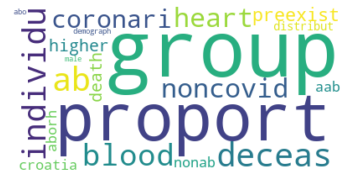


---------- 61697 ------------


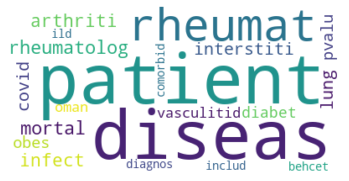


---------- 55569 ------------


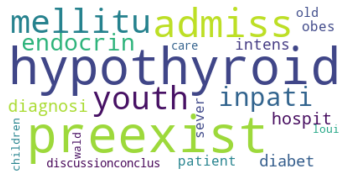


---------- 500374 ------------


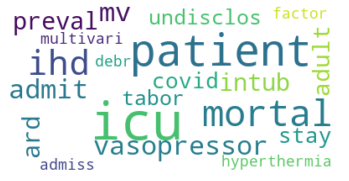


---------- 555541 ------------


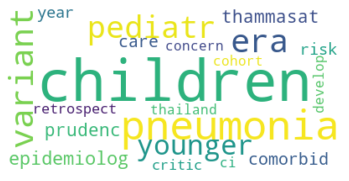


---------- 125596 ------------


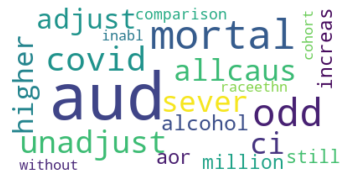


---------- 175869 ------------


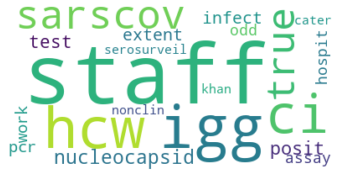


---------- 186500 ------------


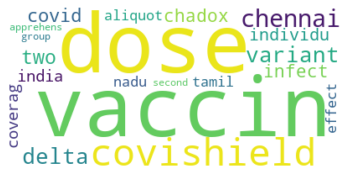


---------- 175982 ------------


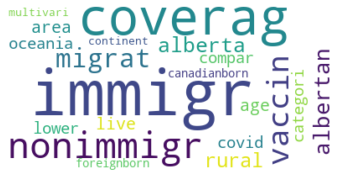


---------- 114811 ------------


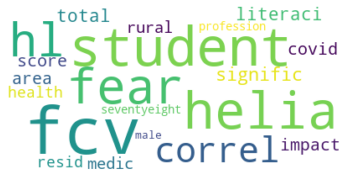


---------- 193406 ------------


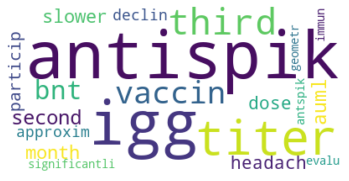


---------- 187269 ------------


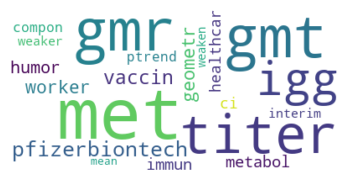


---------- 534237 ------------


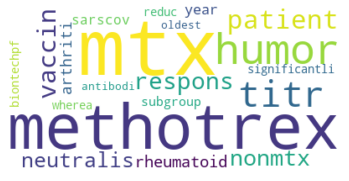


---------- 176821 ------------


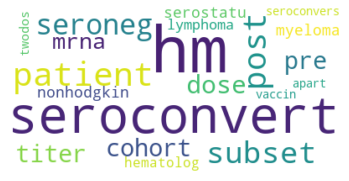


---------- 190516 ------------


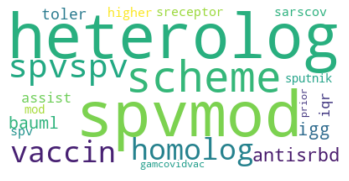


---------- 171989 ------------


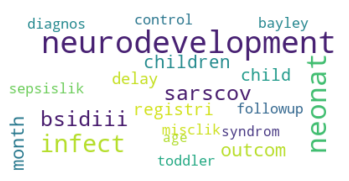


---------- 133491 ------------


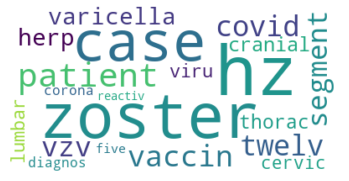


---------- 706638 ------------


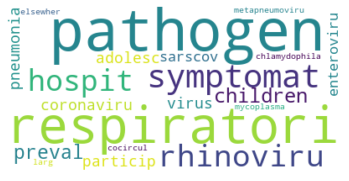


---------- 543725 ------------


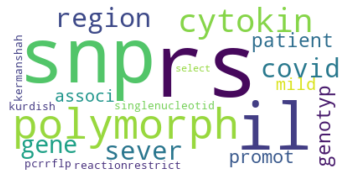


---------- 51121 ------------


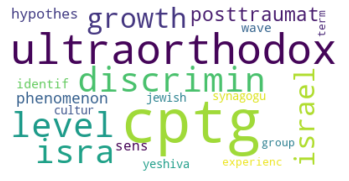


---------- 715517 ------------


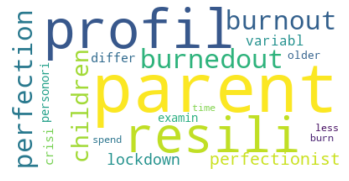


---------- 531160 ------------


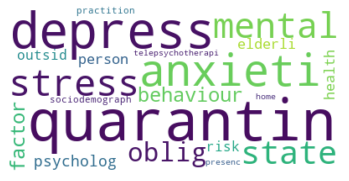

In [ ]:
# to plot word cloud
import matplotlib.pyplot as plt
from wordcloud import WordCloud
for story in total_dict_ji[story_picked]:
  word_cloud = WordCloud(collocations = False, background_color = 'white').generate(word_cloud_frequency_ji[story])
  print('---------- {} ------------'.format(story))
  plt.imshow(word_cloud, interpolation='bilinear')
  plt.axis("off")
  plt.show()
  print()

---------- 768236 ------------


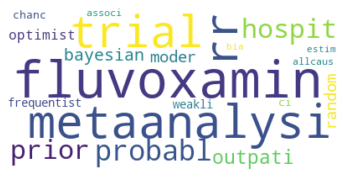


---------- 496735 ------------


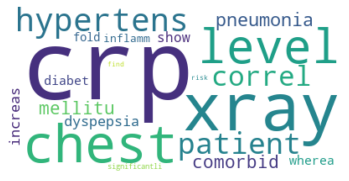


---------- 111954 ------------


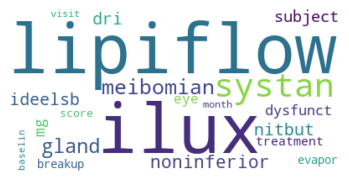


---------- 634381 ------------


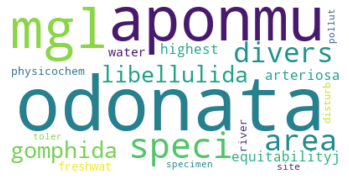


---------- 197850 ------------


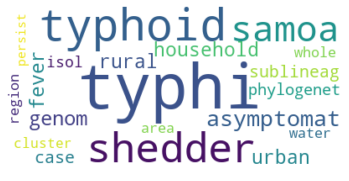


---------- 705503 ------------


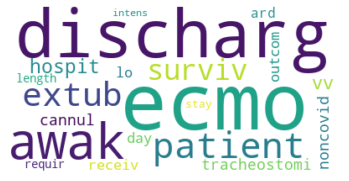


---------- 109404 ------------


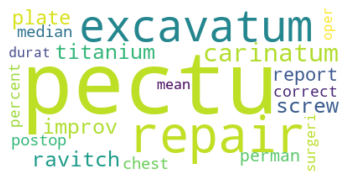


---------- 697995 ------------


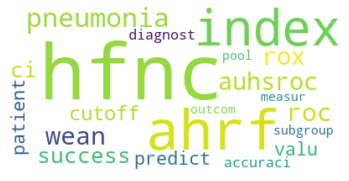


---------- 671078 ------------


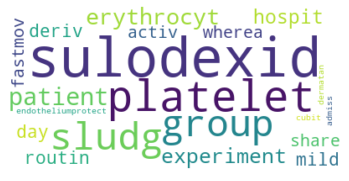


---------- 726325 ------------


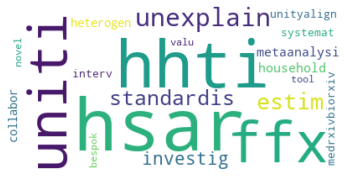


---------- 544190 ------------


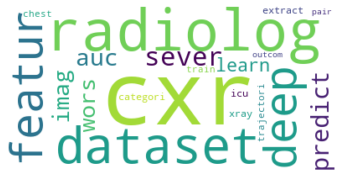


---------- 23787 ------------


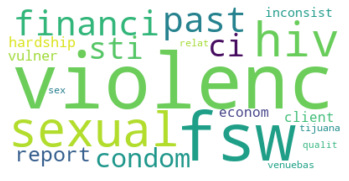


---------- 707385 ------------


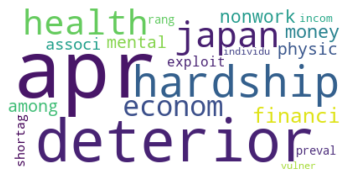


---------- 521913 ------------


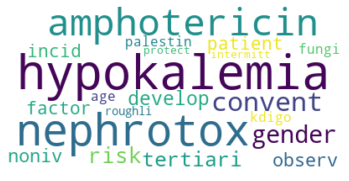


---------- 663578 ------------


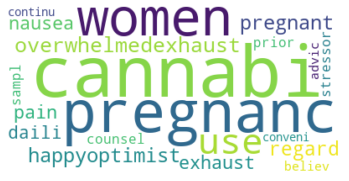


---------- 24184 ------------


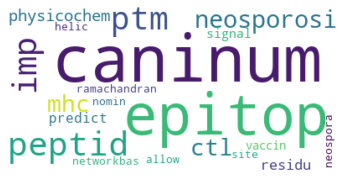


---------- 770998 ------------


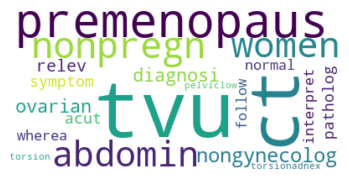


---------- 719867 ------------


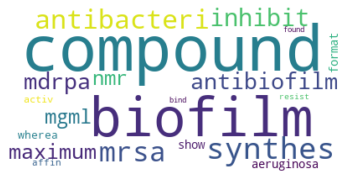


---------- 672298 ------------


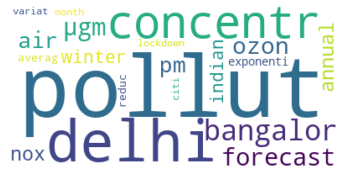


---------- 668431 ------------


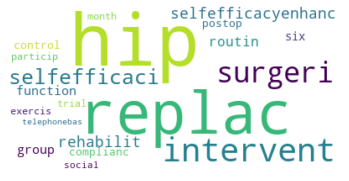


---------- 68707 ------------


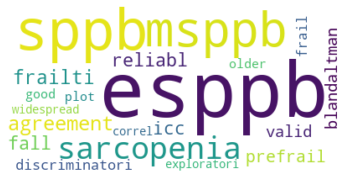


---------- 24008 ------------


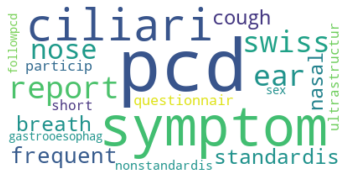


---------- 531772 ------------


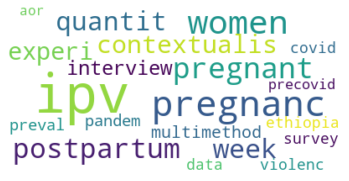


---------- 520474 ------------


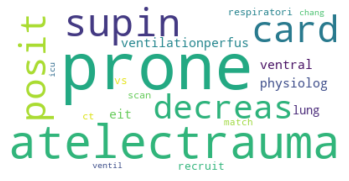


---------- 550699 ------------


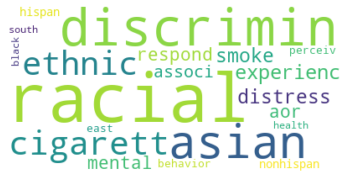


---------- 594406 ------------


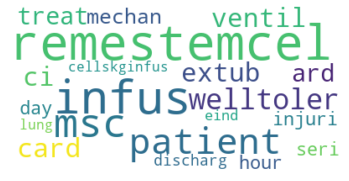


---------- 671324 ------------


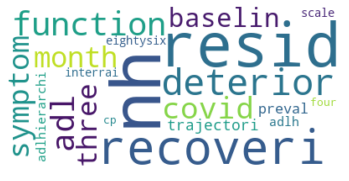


---------- 510060 ------------


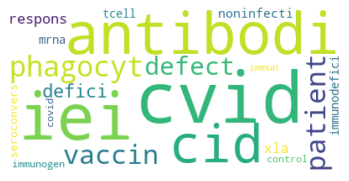


---------- 492195 ------------


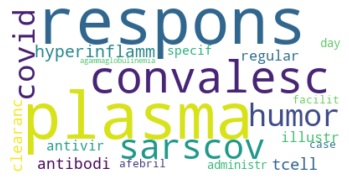


---------- 647907 ------------


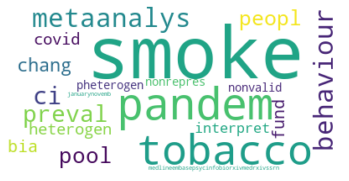


---------- 122130 ------------


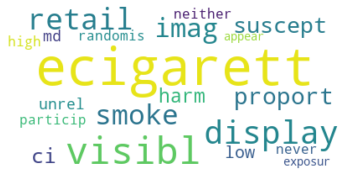


---------- 567646 ------------


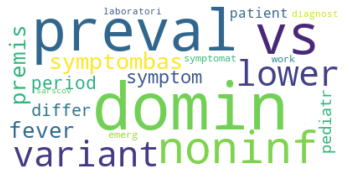


---------- 662792 ------------


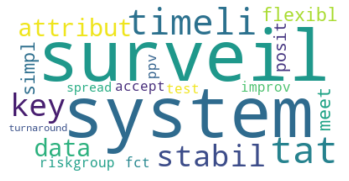


---------- 71107 ------------


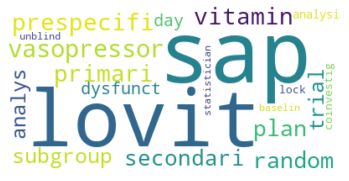


---------- 645692 ------------


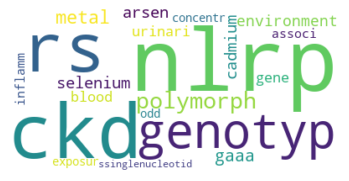


---------- 586389 ------------


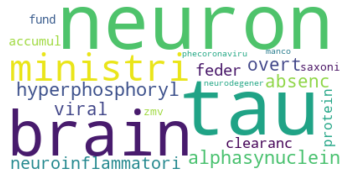


---------- 50954 ------------


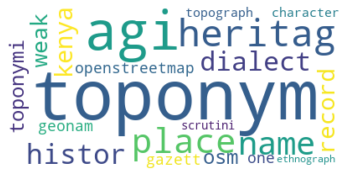


---------- 175238 ------------


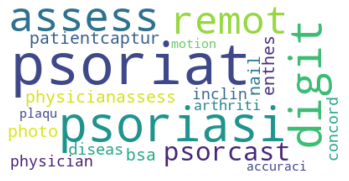


---------- 184681 ------------


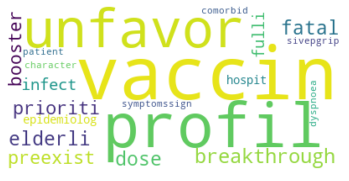


---------- 142474 ------------


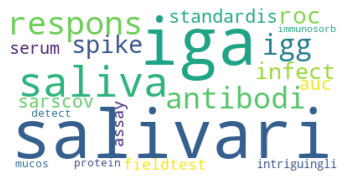


---------- 670676 ------------


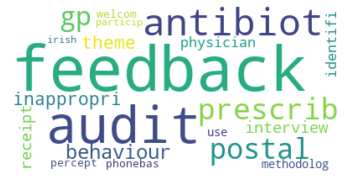


---------- 755569 ------------


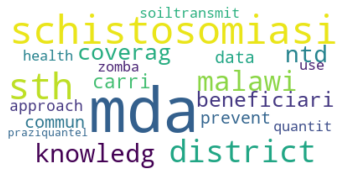


---------- 160545 ------------


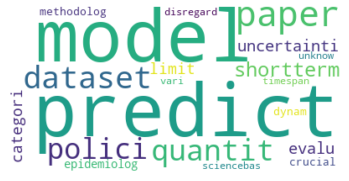


---------- 51215 ------------


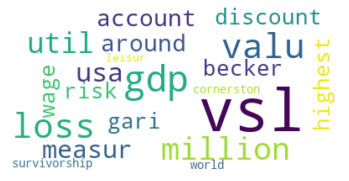


---------- 58431 ------------


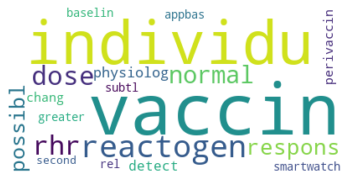


---------- 51273 ------------


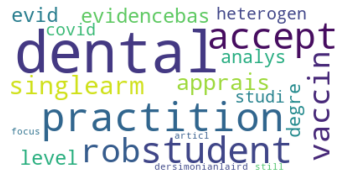


---------- 556465 ------------


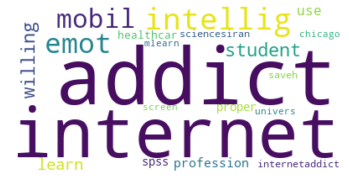

In [ ]:
# to plot word cloud
import matplotlib.pyplot as plt
from wordcloud import WordCloud
for story in total_dict_doc2vec[story_picked]:
  word_cloud = WordCloud(collocations = False, background_color = 'white').generate(word_cloud_frequency_doc2vec[story])
  print('---------- {} ------------'.format(story))
  plt.imshow(word_cloud, interpolation='bilinear')
  plt.axis("off")
  plt.show()
  print()

In [ ]:
# to show how the story 56 goes
print(total_dict_proposed[story_picked].keys())
print(df.shape)
print(len(total_dict_proposed[story_picked].keys()))
print(df.columns)
story_dict = dict()
for ind, row in df.iterrows():
  if row['id'] in total_dict_proposed[story_picked].keys():
    story_dict[row['id']]= [row['content'], row['publish_time']]
for story_id in total_dict_proposed[story_picked].keys():
  print(story_id, '  ', story_dict[story_id][1], '  ', story_dict[story_id][0])


# to show how the story 56 goes
print(total_dict_bert[story_picked].keys())
print(df.shape)
print(len(total_dict_bert[story_picked].keys()))
print(df.columns)
story_dict = dict()
for ind, row in df.iterrows():
  if row['id'] in total_dict_bert[story_picked].keys():
    story_dict[row['id']]= [row['content'], row['publish_time']]
for story_id in total_dict_bert[story_picked].keys():
  print(story_id, '  ', story_dict[story_id][1], '  ', story_dict[story_id][0])


# to show how the story 56 goes
print(total_dict_ji[story_picked].keys())
print(df.shape)
print(len(total_dict_ji[story_picked].keys()))
print(df.columns)
story_dict = dict()
for ind, row in df.iterrows():
  if row['id'] in total_dict_ji[story_picked].keys():
    story_dict[row['id']]= [row['content'], row['publish_time']]
for story_id in total_dict_ji[story_picked].keys():
  print(story_id, '  ', story_dict[story_id][1], '  ', story_dict[story_id][0])



# to show how the story 56 goes
print(total_dict_doc2vec[story_picked].keys())
print(df.shape)
print(len(total_dict_doc2vec[story_picked].keys()))
print(df.columns)
story_dict = dict()
for ind, row in df.iterrows():
  if row['id'] in total_dict_doc2vec[story_picked].keys():
    story_dict[row['id']]= [row['content'], row['publish_time']]
for story_id in total_dict_doc2vec[story_picked].keys():
  print(story_id, '  ', story_dict[story_id][1], '  ', story_dict[story_id][0])

dict_keys([768236, 669209, 98547, 522347, 534828, 691757, 543885, 51157, 50586, 543306, 775204, 634083, 610772, 703619, 50820, 650456, 530729, 563747, 92988, 23936, 662042, 770998, 711972, 769272, 714878, 625414, 655983, 507522, 135984, 588902, 129957, 51091, 85977, 641631, 675858, 81355, 713586, 50947, 748209, 114811, 764882, 184331, 142474, 711756, 774591, 536160, 165446, 160545, 51147, 715517, 23586])
(2209, 5)
51
Index(['id', 'title', 'content', 'publish_time', 'author'], dtype='object')
768236    04012022    Importance Widely available and affordable options for the outpatient management of COVID19 are needed particularly for therapies that prevent hospitalization Objective To perform a metaanalysis of the available randomized clinical trial evidence for fluvoxamine in the outpatient management of COVID19 Data Sources World Health Organization International Clinical Trials Registry Platform and ClinicalTrialsgov Study Selection Studies with completed outpatient trials with availab

In [ ]:
from tqdm import tqdm 
doc_embedding = dict()
for ts_ in tqdm(df_embedding.keys()):
  for doc in df_embedding[ts_].keys():
    doc_embedding[doc] =df_embedding[ts_][doc]['cls']

100%|██████████| 21/21 [00:00<00:00, 4320.00it/s]


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
def consecutive_embedding_changes(emb_list):
  temp_list = list()
  for x, y in zip(emb_list[0:-1], emb_list[1:]):
    temp_list.append(cosine_similarity([x],[y])[0][0])
  return temp_list



In [ ]:
embed_astory_list_proposed = list()
for story in total_dict_proposed[story_picked]:
  embed_astory_list_proposed.append(list(doc_embedding[story]))
cosine_proposed = consecutive_embedding_changes(embed_astory_list_proposed)

embed_astory_list_bert = list()
for story in total_dict_bert[story_picked]:
  embed_astory_list_bert.append(list(doc_embedding[story]))
cosine_bert = consecutive_embedding_changes(embed_astory_list_bert)

embed_astory_list_ji = list()
for story in total_dict_ji[story_picked]:
  embed_astory_list_ji.append(list(doc_embedding[story]))
cosine_ji = consecutive_embedding_changes(embed_astory_list_ji)

embed_astory_list_doc2vec = list()
for story in total_dict_doc2vec[story_picked]:
  embed_astory_list_doc2vec.append(list(doc_embedding[story]))
cosine_doc2vec = consecutive_embedding_changes(embed_astory_list_doc2vec)

In [ ]:
# importing package
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(10,5))  
# create data
y = list(cosine_proposed)
x = [x for x in range(len(y))]
plt.plot(x, y, label = "Our CoRBS", linestyle="-." )
plt.xlabel('The series of document in a story')
plt.ylabel('Cosine similarity changes')

y = list(cosine_bert)
x = [x for x in range(len(y))]
plt.plot(x, y, label = "Bert", linestyle="-." )


y = list(cosine_ji)
x = [x for x in range(len(y))]
plt.plot(x, y, label = "Entity-set based", linestyle="-." )

y = list(cosine_doc2vec)
x = [x for x in range(len(y))]
plt.plot(x, y, label = "doc2vec", linestyle="-." )


plt.legend()
plt.show()

In [ ]:
# importing package
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(10,5))  
# create data
y = [(cosine_proposed[x]+cosine_proposed[x+1]+cosine_proposed[x+2]+cosine_proposed[x+3]+cosine_proposed[x+4])/5 for x in range(0,len(cosine_proposed)-5,5)]
x = [x for x in range(len(y))]
plt.plot(x, y, label = "Our CoRBS", linestyle="-." )
plt.xlabel('The series of document in a story')
plt.ylabel('Cosine similarity changes')

y = y = [(cosine_bert[x]+cosine_bert[x+1]+cosine_bert[x+2]+cosine_bert[x+3]+cosine_bert[x+4])/5 for x in range(0,len(cosine_bert)-5,5)]
x = [x for x in range(len(y))]
plt.plot(x, y, label = "Bert", linestyle="-." )


y = y = [(cosine_ji[x]+cosine_ji[x+1]+cosine_ji[x+2]+cosine_ji[x+3]+cosine_ji[x+4])/5 for x in range(0,len(cosine_ji)-5,5)]
x = [x for x in range(len(y))]
plt.plot(x, y, label = "Entity-set based", linestyle="-." )

y = y = [(cosine_doc2vec[x]+cosine_doc2vec[x+1]+cosine_doc2vec[x+2]+cosine_doc2vec[x+3]+cosine_doc2vec[x+4])/5 for x in range(0,len(cosine_doc2vec)-5,5)]
x = [x for x in range(len(y))]
plt.plot(x, y, label = "doc2vec", linestyle="-." )


plt.legend()
plt.show()

In [ ]:
total_dict = dict()

for total in range(len(story_data[0.9])):
  sampl = story_data[0.9][total]
  keyword_story = dict()
  for doc_1, doc_2 in zip(sampl[:-1], sampl[1:]):
    keyword_story[doc_1] = jaccard_similarity(top_keywords[doc_1].keys(), top_keywords[doc_2].keys())
  total_dict[total] = keyword_story


chan_dict = dict()
for st in total_dict.keys():
  if len(total_dict[st]) > 4:
    chan_dict[st] =sum(list(total_dict[st].values()))
ind = sorted(chan_dict.values())
list_of_stories = list()
# for z in range(len(ind)):
for t, v in chan_dict.items():
  if v == ind[-1]:
    print(t, ' -> ', total_dict[t])
    list_of_stories.append(t)